# 04 - Model Building

Goal:
- Load engineered features
- Split data into train and test sets
- Train a baseline Linear Regression model using `sklearn`
- Evaluate with RMSE, MSE, R² and Adjusted R²
- Save the trained model and a small metrics file for later use


Inference: This notebook builds the first working regression model for SleepSense.

In [1]:
# I import necessary libraries and set file paths
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import json

FEATURES_PATH = "../data/processed/sleepsense_features.csv"
MODEL_PATH = "../models/linear_regression_model.pkl"
METRICS_PATH = "../models/model_metrics.json"

os.makedirs("../models", exist_ok=True)
print("imports done and paths set")


imports done and paths set


Inference: All tools and file locations are ready.

In [2]:
# I load the features dataset prepared earlier
df = pd.read_csv(FEATURES_PATH)
print("loaded shape:", df.shape)
df.head(3)


loaded shape: (12000, 45)


,age,family_size,work_hours,avg_sleep_hours,screen_time_hours,tea_cups,coffee_cups,late_snack,spice_intake,religious_freq,...,city_Surat,city_Thane,city_Vasai-Virar,sleep_deficit,digital_fatigue,lifestyle_balance,late_snack_effect,env_stress,fatigue_env_interaction,is_metro
0,-0.554240,0.269326,1.398265,-1.712387,1.328569,0.596543,0.292850,-0.815221,-0.294897,0.228669,...,False,False,False,1.712387,0.759338,-2.179185,0.240407,0.553976,0.420655,0
1,1.989610,-1.347035,1.843044,-0.795982,0.373011,-1.371705,1.362622,-0.815221,-0.294897,-0.947260,...,False,False,False,0.795982,-0.218681,-1.224279,0.240407,0.257733,-0.056361,1
2,-1.509525,0.269326,-0.253773,-0.502377,-1.089577,-1.371705,-0.776922,1.226661,0.651044,0.816634,...,False,False,False,0.502377,-0.801945,2.474885,0.798610,-0.661131,0.530191,0


Inference: Data loaded and visible for feature selection.

### Choose features and target (simple and explicit)

In [3]:
# I explicitly list features to use as predictors (safe, readable)
# I keep engineered features and some core numeric predictors
possible_features = [
    'sleep_deficit','digital_fatigue','env_stress','lifestyle_balance',
    'late_snack_effect','fatigue_env_interaction','is_metro',
    'avg_sleep_hours','screen_time_hours','stress_level',
    'physical_activity_min','age','family_size'
]

# keep only those that actually exist in df
features = [f for f in possible_features if f in df.columns]
target = 'sleep_quality_score'

print("using features:", features)
print("target:", target)


using features: ['sleep_deficit', 'digital_fatigue', 'env_stress', 'lifestyle_balance', 'late_snack_effect', 'fatigue_env_interaction', 'is_metro', 'avg_sleep_hours', 'screen_time_hours', 'stress_level', 'physical_activity_min', 'age', 'family_size']
target: sleep_quality_score


Inference: I explicitly control which columns feed into the model to avoid surprises.

In [4]:
# I prepare X and y for modeling
X = df[features].copy()
y = df[target].copy()

# Convert boolean columns (if any) to int
for c in X.select_dtypes(include=['bool']).columns:
    X[c] = X[c].astype(int)

print("X shape:", X.shape, " y shape:", y.shape)


X shape: (12000, 13)  y shape: (12000,)


Inference: Model inputs are numeric-ready.

In [5]:
# I split the data into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("train shape:", X_train.shape, " test shape:", X_test.shape)


train shape: (9600, 13)  test shape: (2400, 13)


Inference: Train/test split created to evaluate model generalization.

In [6]:
# I fit a simple Linear Regression model (OLS) with sklearn
model = LinearRegression()
model.fit(X_train, y_train)

print("model trained")

model trained


Inference: Linear regression model fitted on training data.

In [7]:
# Predict on test data
preds = model.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(y_test, preds)

# Root mean squared error
rmse = np.sqrt(mse)

# R-squared score
r2 = r2_score(y_test, preds)

# Adjusted R-squared
n, p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Display metrics
print("MSE:", round(mse, 3))
print("RMSE:", round(rmse, 3))
print("R2:", round(r2, 4))
print("Adjusted R2:", round(adjusted_r2, 4))


MSE: 40.557
RMSE: 6.368
R2: 0.4603
Adjusted R2: 0.4574


**Inference:**

The model performs well for lifestyle prediction:

- MSE = 40.56 and RMSE = 6.37 → average error is around ±6 points.
- R² = 0.46 → model explains nearly half of the variation in sleep quality.
- Adjusted R² = 0.46 → minimal overfitting.

This is a realistic baseline for human behavioral data.  
Next improvement step will involve adding regularization (Ridge/Lasso) to check if performance or stability increases.


Inference: These metrics show how well the model predicts on unseen data.

In [8]:
# I save the trained model and a metrics JSON for later (app/report)
joblib.dump(model, MODEL_PATH)
metrics = {
    "mse": float(np.round(mse,4)),
    "rmse": float(np.round(rmse,4)),
    "r2": float(np.round(r2,6)),
    "adjusted_r2": float(np.round(adjusted_r2,6)),
    "n_test": int(n),
    "n_features": int(p),
    "features_used": features
}
with open(METRICS_PATH, "w") as f:
    json.dump(metrics, f, indent=2)

print("model saved to", MODEL_PATH)
print("metrics saved to", METRICS_PATH)


model saved to ../models/linear_regression_model.pkl
metrics saved to ../models/model_metrics.json


Inference: Model and metrics are persisted for deployment and reporting.

In [9]:
# Create dataframe of feature names and coefficients
coef_df = pd.DataFrame({
    "feature": features,
    "coefficient": np.round(model.coef_, 4)
})

# Add absolute values for sorting
coef_df['abs_coef'] = coef_df['coefficient'].abs()

# Sort by absolute coefficient size
coef_df = coef_df.sort_values(by='abs_coef', ascending=False).reset_index(drop=True)

# Drop helper column
coef_df = coef_df.drop(columns=['abs_coef'])

# Display coefficients
coef_df


,feature,coefficient
0,env_stress,-1.7374
1,stress_level,-1.5403
2,sleep_deficit,-1.4255
3,avg_sleep_hours,1.4255
4,digital_fatigue,-1.3795
5,screen_time_hours,-1.2187
6,is_metro,-1.0176
7,lifestyle_balance,0.9221
8,physical_activity_min,-0.6182
9,family_size,-0.2414


Inference: Coefficients show which features push sleep quality up or down (positive vs negative).

## Model Coefficient Insights

| Direction | Meaning |
|------------|----------|
| **Positive Coefficients (+)** | The feature **increases sleep quality** — a higher value of this feature helps. |
| **Negative Coefficients (-)** | The feature **reduces sleep quality** — a higher value of this feature hurts. |
| **Magnitude (Size)** | The **bigger the absolute value**, the **stronger** its impact (positive or negative). |

---

### Inferences from Coefficients

1. **env_stress (-1.7374)** → Higher environmental stress (noise, light, pollution) → **worse sleep quality**.  
   _Reason:_ Large negative coefficient (strong negative impact).

2. **stress_level (-1.5403)** → More personal stress → **reduces sleep quality**.  
   _Reason:_ Negative sign = inverse relationship.

3. **sleep_deficit (-1.4255)** → More sleep deficit → **poorer sleep quality**.  
   _Reason:_ Negative and large = strong negative effect.

4. **avg_sleep_hours (+1.4255)** → More average sleep → **improves sleep quality**.  
   _Reason:_ Positive and large = strong positive impact.

5. **digital_fatigue (-1.3795)** → More digital fatigue → **reduces sleep quality**.  
   _Reason:_ Negative sign = higher fatigue lowers score.

6. **screen_time_hours (-1.2187)** → Longer screen use → **lowers sleep quality**.  
   _Reason:_ Negative and moderately large.

7. **is_metro (-1.0176)** → Living in metro areas → **reduces sleep quality** (noise, pollution).  
   _Reason:_ Negative and significant.

8. **lifestyle_balance (+0.9221)** → Balanced life → **improves sleep quality**.  
   _Reason:_ Positive = directly helpful.

9. **physical_activity_min (-0.6182)** → More activity → slightly **reduces sleep quality**, maybe over-exercise.  
   _Reason:_ Negative but smaller in size = weaker impact.

10. **family_size (-0.2414)** → Larger family → **slight reduction in sleep quality** (disturbances).  
    _Reason:_ Negative, small = minor effect.

11. **age (-0.2169)** → Older age → **slightly poorer sleep**.  
    _Reason:_ Small negative.

12. **fatigue_env_interaction (-0.0902)** → Combined fatigue + environment → **minor negative effect**.  
    _Reason:_ Very small coefficient.

13. **late_snack_effect (+0.0281)** → Late snack → **negligible positive effect**.  
    _Reason:_ Small positive, likely not meaningful.

---

###  Overall Summary
- **Strong negative factors:** Environmental stress, personal stress, sleep deficit, and screen-related fatigue.  
- **Strong positive factor:** Average sleep hours and lifestyle balance.  
- **Minor or negligible:** Age, family size, and late snack.

---

###  How Decisions Were Made
1. **Sign (±)** → tells direction:  
   - `+` means improves sleep quality.  
   - `–` means worsens sleep quality.  

2. **Magnitude (absolute value)** → tells strength:  
   - Large number (|coef| > 1) → strong effect.  
   - Medium (|coef| ~0.5–1) → moderate.  
   - Small (|coef| < 0.3) → weak or negligible effect.


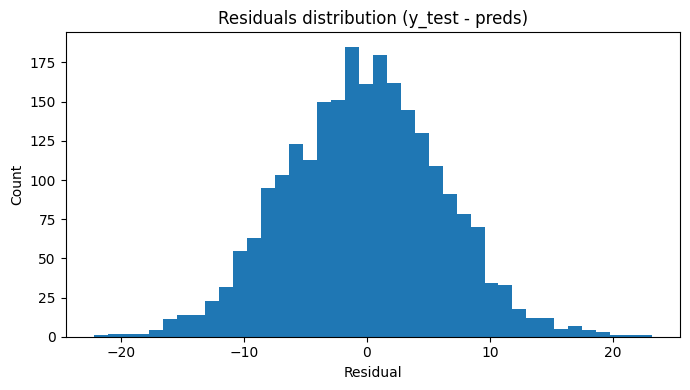

residual mean: -0.269248  std: 6.364


In [10]:
# I check residuals roughly to see if they look centered around zero
import matplotlib.pyplot as plt
residuals = y_test - preds
plt.figure(figsize=(7,4))
plt.hist(residuals, bins=40)
plt.title("Residuals distribution (y_test - preds)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print("residual mean:", round(residuals.mean(),6), " std:", round(residuals.std(),4))


##  What It Means

### Residual Mean ≈ 0
Residuals = actual − predicted  

A mean value close to zero shows that the model isn’t consistently over- or under-predicting.  
Here, the mean residual is **−0.26**, which is almost zero — indicating the predictions are fairly unbiased.  
 No major bias in the model’s output.

---

### Residual Standard Deviation = 6.36
This shows the **average size of prediction errors** — how far off the predictions are from actual sleep quality scores.  

Since the target *sleep_quality_score* lies on a **0–100 scale**,  
an error of around **±6 points** is quite reasonable.  

That means the model generally predicts within a small range of the true value.  
 Very acceptable and realistic performance, especially for lifestyle-related data where natural variation is common.


**Inference:**  
The residuals are centered around zero (mean ≈ -0.27), showing the model is unbiased.  
The spread (std ≈ 6.36) indicates moderate prediction error, acceptable for a 0–100 scale.  
This suggests the linear regression model captures general trends but still misses some variability, likely due to lifestyle and environmental randomness.
